In [5]:
!pip install scikit-learn matplotlib

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.2/162.2 kB 1.8 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 13.2 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.0/306.0 kB 12.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 13.8 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 15.6 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.2/103.2 kB 12.0 MB/s eta 0:00:00


In [1]:
import os
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset,random_split
from torchvision import datasets, transforms
from sklearn.preprocessing import MinMaxScaler

import pandas as pd
import numpy as np
import math

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
device

'cuda'

In [3]:
data = pd.read_csv("./csv/dummyData-0.csv")
dat = data.iloc[::,1::]

In [4]:
data['date'] = pd.to_datetime(data['date'], errors='coerce')

data = data.dropna(subset=['date'])

data = data.sort_values('date')

data = data.drop_duplicates(subset='date')

avail = data['avail'].values


In [5]:
data

,Unnamed: 0,date,avail
0,0,2021-01-01,1
1,1,2021-01-02,1
2,2,2021-01-03,0
3,3,2021-01-04,0
4,4,2021-01-05,0
...,...,...,...
1090,1090,2023-12-27,1
1091,1091,2023-12-28,1
1092,1092,2023-12-29,1
1093,1093,2023-12-30,0


In [6]:
scaler = MinMaxScaler(feature_range=(0, 1))
avail = scaler.fit_transform(avail.reshape(-1, 1))

# Prepare the dataset for the RNN
sequence_length = 7  # Number of previous days to use for prediction

def create_sequences(data, seq_length):
    xs, ys = [], []
    for i in range(len(data)-seq_length):
        x = data[i:i+seq_length]
        y = data[i+seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)

In [7]:
X, y = create_sequences(avail, sequence_length)

In [8]:
X[-1] ,y[-1]

(array([[1.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.],
        [0.]]),
 array([0.]))

In [9]:
class AvailabilityDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        return self.X[index], self.y[index]

dataset = AvailabilityDataset(X, y)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)


In [10]:
class RNNModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=50, output_size=1, num_layers=2):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return torch.sigmoid(out)

model = RNNModel()


In [11]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Training loop
num_epochs = 1000

for epoch in range(num_epochs):
    for X_batch, y_batch in dataloader:
        # Forward pass
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        # print(torch.round(outputs),y_batch)
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    if (epoch+1) % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


Epoch [10/1000], Loss: 0.6889
Epoch [20/1000], Loss: 0.7286
Epoch [30/1000], Loss: 0.7499
Epoch [40/1000], Loss: 0.6782
Epoch [50/1000], Loss: 0.7002
Epoch [60/1000], Loss: 0.7595
Epoch [70/1000], Loss: 0.7185
Epoch [80/1000], Loss: 0.6940
Epoch [90/1000], Loss: 0.6893
Epoch [100/1000], Loss: 0.6853
Epoch [110/1000], Loss: 0.6854
Epoch [120/1000], Loss: 0.6915
Epoch [130/1000], Loss: 0.6921
Epoch [140/1000], Loss: 0.6909
Epoch [150/1000], Loss: 0.7284
Epoch [160/1000], Loss: 0.6977
Epoch [170/1000], Loss: 0.7074
Epoch [180/1000], Loss: 0.7760
Epoch [190/1000], Loss: 0.6928
Epoch [200/1000], Loss: 0.7439
Epoch [210/1000], Loss: 0.6914
Epoch [220/1000], Loss: 0.6913
Epoch [230/1000], Loss: 0.7018
Epoch [240/1000], Loss: 0.6913
Epoch [250/1000], Loss: 0.7196
Epoch [260/1000], Loss: 0.6912
Epoch [270/1000], Loss: 0.6970
Epoch [280/1000], Loss: 0.6919
Epoch [290/1000], Loss: 0.6912
Epoch [300/1000], Loss: 0.7267
Epoch [310/1000], Loss: 0.6936
Epoch [320/1000], Loss: 0.7032
Epoch [330/1000],

In [49]:
def predict(model, X):
    model.eval()
    with torch.no_grad():
        X = torch.tensor(X, dtype=torch.float32)
        prediction = model(X)
        return prediction.item()


last_sequence = avail[-sequence_length:]
for i in range(10):
    last_sequence = np.concatenate((last_sequence[1:],np.array([[i%2]])))
    print(last_sequence)
    next_day_avail = predict(model, last_sequence.reshape(1, sequence_length, 1))
    print(f'Predicted availability for the next day: {round(next_day_avail)}')


[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]]
Predicted availability for the next day: 0
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]]
Predicted availability for the next day: 1
[[1.]
 [0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]]
Predicted availability for the next day: 0
[[0.]
 [1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]]
Predicted availability for the next day: 1
[[1.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
Predicted availability for the next day: 0
[[0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
Predicted availability for the next day: 1
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
Predicted availability for the next day: 1
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
Predicted availability for the next day: 0
[[0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]]
Predicted availability for the next day: 1
[[1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]]
Predicted availability for the next day: 0


In [37]:
torch.save(model,"./model/RNNmodelDummySet-Lose_60%.h5")

/home/viki/AquaSense/pi4/ml-ai/RNN Model


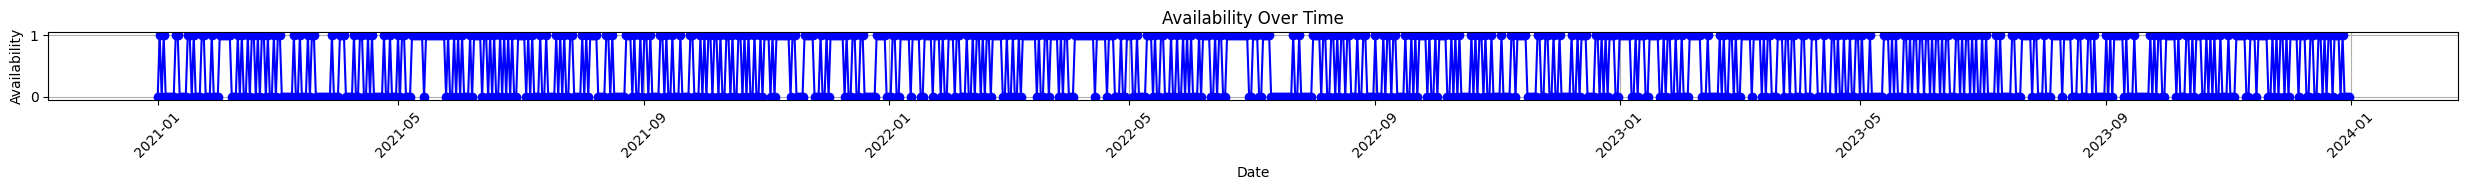

In [24]:
import pandas as pd
import matplotlib.pyplot as plt


data =dat.iloc[:]
data['date'] = pd.to_datetime(data['date'], errors='coerce')


data = data.dropna(subset=['date'])


data = data.sort_values('date')


data['avail'] = pd.to_numeric(data['avail'], errors='coerce')

data = data.dropna(subset=['avail'])


plt.figure(figsize=(25, 2))
plt.plot(data['date'], data['avail'], marker='o', color='b')


plt.title('Availability Over Time')
plt.xlabel('Date')
plt.ylabel('Availability')
plt.grid(True)


plt.xticks(rotation=45)

plt.tight_layout()
plt.show()
